# Drug Consumption

## Data Understanding
### Import von benötigten Bibliotheken

In [31]:
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import numpy as np

### Datensatz abrufen

In [32]:
dataset = fetch_ucirepo(id=373)

### Daten (Features und Zielvariable)

In [33]:
X = dataset.data.features.drop(columns=['age', 'gender'], errors='ignore')
y = dataset.data.targets

### Erste Übersicht der Features und der Zielvariablen

In [34]:
print("Übersicht der Merkmale:")
print(X.head())

print("")
print("Übersicht der Targets in den Zielklassen:")
print(y.head())

print("")
print("Übersicht über Datentypen im Datensatz")
print(X.dtypes)
print(y.dtypes)

Übersicht der Merkmale:
   education  country  ethnicity   nscore   escore   oscore   ascore   cscore  \
0   -0.05921  0.96082    0.12600  0.31287 -0.57545 -0.58331 -0.91699 -0.00665   
1    1.98437  0.96082   -0.31685 -0.67825  1.93886  1.43533  0.76096 -0.14277   
2   -0.05921  0.96082   -0.31685 -0.46725  0.80523 -0.84732 -1.62090 -1.01450   
3    1.16365  0.96082   -0.31685 -0.14882 -0.80615 -0.01928  0.59042  0.58489   
4    1.98437  0.96082   -0.31685  0.73545 -1.63340 -0.45174 -0.30172  1.30612   

   impuslive       ss  
0   -0.21712 -1.18084  
1   -0.71126 -0.21575  
2   -1.37983  0.40148  
3   -1.37983 -1.18084  
4   -0.21712 -0.21575  

Übersicht der Targets in den Zielklassen:
  alcohol amphet amyl benzos caff cannabis choc coke crack ecstasy heroin  \
0     CL5    CL2  CL0    CL2  CL6      CL0  CL5  CL0   CL0     CL0    CL0   
1     CL5    CL2  CL2    CL0  CL6      CL4  CL6  CL3   CL0     CL4    CL0   
2     CL6    CL0  CL0    CL0  CL6      CL3  CL4  CL0   CL0     CL0    C

### Lage- und Streuungsmaße

Lage- und Streuungsmaße der Features:
         education      country    ethnicity       nscore       escore  \
count  1885.000000  1885.000000  1885.000000  1885.000000  1885.000000   
mean     -0.003806     0.355542    -0.309577     0.000047    -0.000163   
std       0.950078     0.700335     0.166226     0.998106     0.997448   
min      -2.435910    -0.570090    -1.107020    -3.464360    -3.273930   
25%      -0.611130    -0.570090    -0.316850    -0.678250    -0.695090   
50%      -0.059210     0.960820    -0.316850     0.042570     0.003320   
75%       0.454680     0.960820    -0.316850     0.629670     0.637790   
max       1.984370     0.960820     1.907250     3.273930     3.273930   

            oscore       ascore       cscore    impuslive           ss  
count  1885.000000  1885.000000  1885.000000  1885.000000  1885.000000  
mean     -0.000534    -0.000245    -0.000386     0.007216    -0.003292  
std       0.996229     0.997440     0.997523     0.954435     0.963701  
min

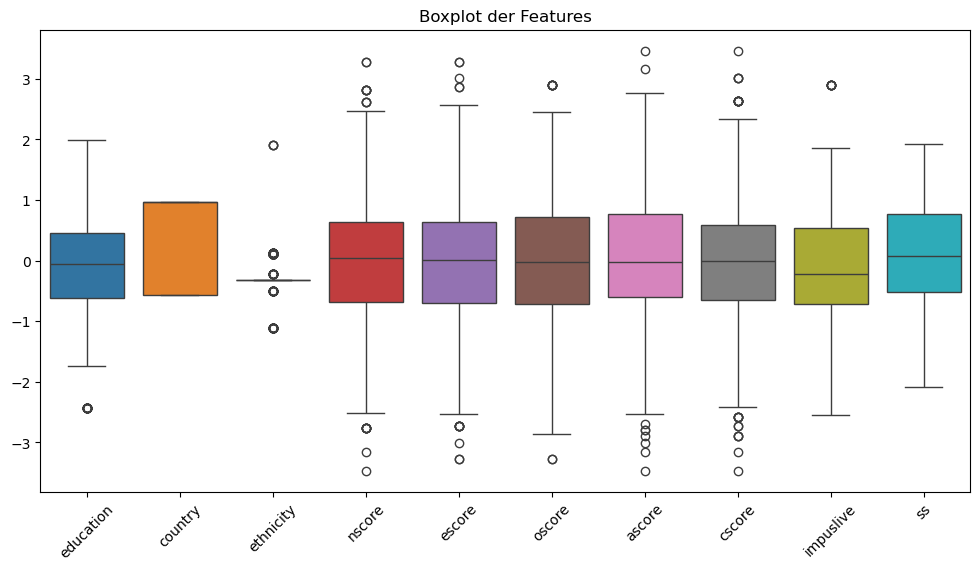

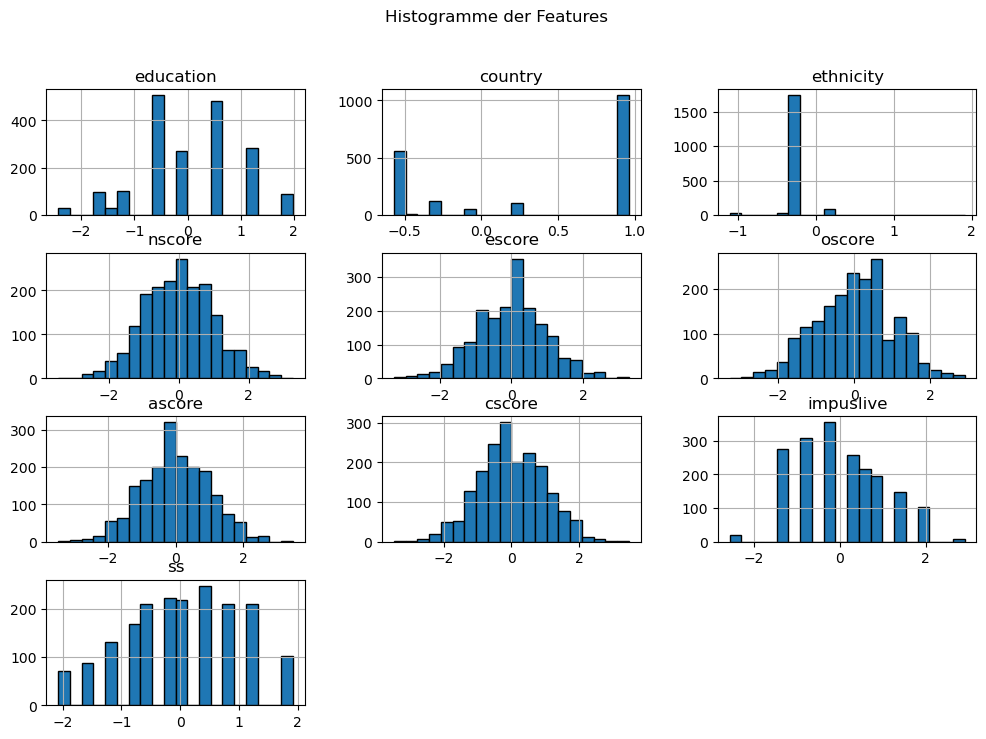

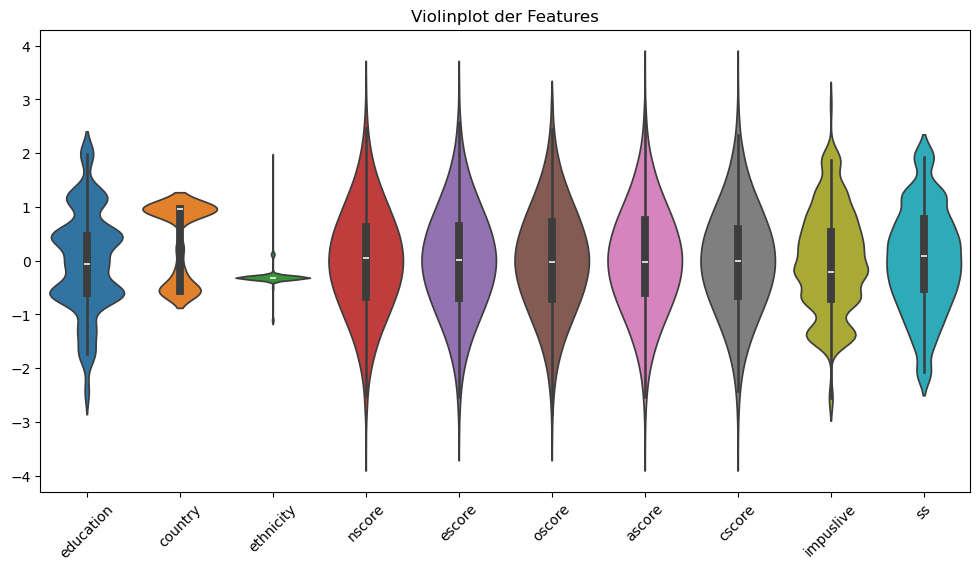

In [35]:
print("Lage- und Streuungsmaße der Features:")
print(X.describe())

plt.figure(figsize=(12, 6))
sns.boxplot(data=X)
plt.xticks(rotation=45)
plt.title("Boxplot der Features")
plt.show()

X.hist(figsize=(12, 8), bins=20, edgecolor="black")
plt.suptitle("Histogramme der Features")
plt.show()

plt.figure(figsize=(12, 6))
sns.violinplot(data=X)
plt.xticks(rotation=45)
plt.title("Violinplot der Features")
plt.show()


### Enthaltene Drogen im Datensatz

In [36]:
drug_columns = ['cannabis', 'coke', 'ecstasy', 'heroin', 'meth', 'mushrooms', 'nicotine', 'lsd', 'amphet', 'crack', 'alcohol']

### Primäre Auswahl an zu analysierenden Drogen

In [37]:
chosen_drugs = ['cannabis', 'coke', 'nicotine'] 

### Visualisierung der Verteilung des Konsums für jede Droge

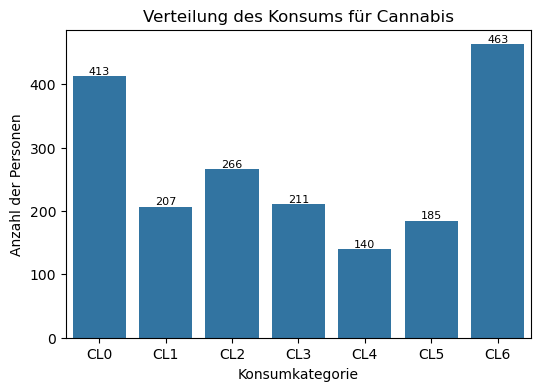

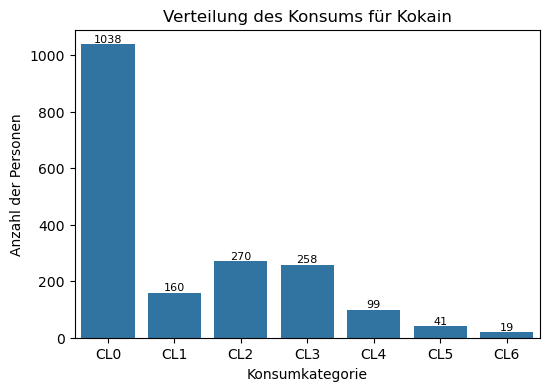

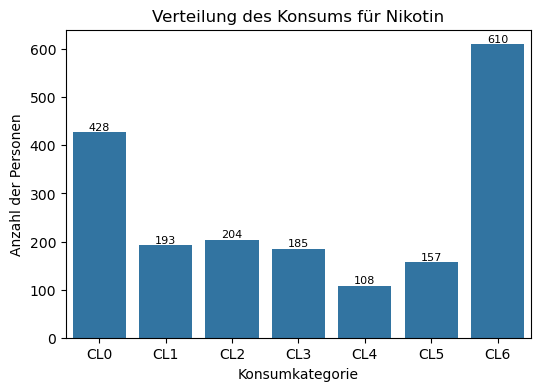

In [38]:
drug_names = {
    'cannabis': 'Cannabis',
    'coke': 'Kokain',
    'nicotine': 'Nikotin',
}

for drug in chosen_drugs:
    plt.figure(figsize=(6, 4))
    
    value_counts = y[drug].value_counts().sort_values(ascending=False)
    
    ordered_categories = ['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6']
    
    ax = sns.countplot(x=y[drug], order=ordered_categories)
    
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height,  
                f'{int(height)}', ha="center", va="bottom", fontsize=8)
    
    plt.title(f"Verteilung des Konsums für {drug_names.get(drug, drug).capitalize()}")
    plt.xlabel('Konsumkategorie')
    plt.ylabel('Anzahl der Personen')
    plt.show()


### Funktion, die Modelle erstellt und evaluiert

--> Zielvariable für die gewählte Droge

In [39]:
drug_names = ['cannabis', 'coke', 'nicotine']
y_selected = y[drug_names]

### Train-Test-Split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y_selected, test_size=0.2, random_state=42)

### Verifizieren des Splits

In [41]:
print("\nTrainingsdaten (Features) : ", X_train.shape)
print("Testdaten (Features) : ", X_test.shape)


Trainingsdaten (Features) :  (1508, 10)
Testdaten (Features) :  (377, 10)


## Decision Tree Modell (parameter finden)

In [42]:
'''dt_models = {}
y_pred_dt = {}

param_grid = {
    'max_depth': [5, 10, 15, 20], 
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 5],            
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None],
}

for drug in drug_names:
    print(f"\nTraining Entscheidungsbaum für {drug}...")
    
 
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train[drug]), y=y_train[drug])
    class_weight_dict = dict(zip(np.unique(y_train[drug]), class_weights))
    
    dt_model = DecisionTreeClassifier(random_state=42, class_weight=class_weight_dict)
    
    grid_search = GridSearchCV(dt_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1) 
    grid_search.fit(X_train, y_train[drug])

    print(f"Beste Parameter für {drug}: {grid_search.best_params_}")

    best_dt_model = grid_search.best_estimator_
    
    dt_models[drug] = best_dt_model
    y_pred_dt[drug] = best_dt_model.predict(X_test)'
    '''

'dt_models = {}\ny_pred_dt = {}\n\nparam_grid = {\n    \'max_depth\': [5, 10, 15, 20], \n    \'min_samples_split\': [2, 4, 6],\n    \'min_samples_leaf\': [1, 2, 5],            \n    \'criterion\': [\'gini\', \'entropy\'],\n    \'max_features\': [\'sqrt\', \'log2\', None],\n}\n\nfor drug in drug_names:\n    print(f"\nTraining Entscheidungsbaum für {drug}...")\n    \n \n    class_weights = compute_class_weight(\'balanced\', classes=np.unique(y_train[drug]), y=y_train[drug])\n    class_weight_dict = dict(zip(np.unique(y_train[drug]), class_weights))\n    \n    dt_model = DecisionTreeClassifier(random_state=42, class_weight=class_weight_dict)\n    \n    grid_search = GridSearchCV(dt_model, param_grid, cv=5, scoring=\'accuracy\', n_jobs=-1) \n    grid_search.fit(X_train, y_train[drug])\n\n    print(f"Beste Parameter für {drug}: {grid_search.best_params_}")\n\n    best_dt_model = grid_search.best_estimator_\n    \n    dt_models[drug] = best_dt_model\n    y_pred_dt[drug] = best_dt_model.predi

In [43]:
dt_models = {}
y_pred_dt = {}

best_params = {
    'cannabis': {'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2},
    'coke': {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2},
    'nicotine': {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
}

for drug in drug_names:
    print(f"\nTraining Entscheidungsbaum für {drug}...")
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train[drug]), y=y_train[drug])
    class_weight_dict = dict(zip(np.unique(y_train[drug]), class_weights))
    
    params = best_params.get(drug, {})
    
    dt_model = DecisionTreeClassifier(random_state=42, class_weight=class_weight_dict, **params)
    
    dt_model.fit(X_train, y_train[drug])
    
    dt_models[drug] = dt_model
    y_pred_dt[drug] = dt_model.predict(X_test)

    print(f"Modell für {drug} erfolgreich trainiert und Vorhersage gespeichert.")


Training Entscheidungsbaum für cannabis...
Modell für cannabis erfolgreich trainiert und Vorhersage gespeichert.

Training Entscheidungsbaum für coke...
Modell für coke erfolgreich trainiert und Vorhersage gespeichert.

Training Entscheidungsbaum für nicotine...
Modell für nicotine erfolgreich trainiert und Vorhersage gespeichert.


## Random Forest Modell

In [44]:
rf_models = {}
y_pred_rf = {}

for drug in drug_names:
    print(f"\nTraining Random Forest für {drug}...")
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train[drug]), y=y_train[drug])
    class_weight_dict = dict(zip(np.unique(y_train[drug]), class_weights))
    
    rf_model = RandomForestClassifier(random_state=42, 
                                  class_weight=class_weight_dict, 
                                  n_estimators=100,
                                  max_depth=10,
                                  max_features='sqrt')
    rf_model.fit(X_train, y_train[drug])
    
    y_pred_rf[drug] = rf_model.predict(X_test)
    rf_models[drug] = rf_model


Training Random Forest für cannabis...

Training Random Forest für coke...

Training Random Forest für nicotine...


### Logistische Regression Modell


In [45]:
logreg_models = {}
y_pred_logreg = {}

for drug in drug_names:
    print(f"\nTraining Logistische Regression für {drug}...")
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train[drug]), y=y_train[drug])
    class_weight_dict = dict(zip(np.unique(y_train[drug]), class_weights))
    
    logreg_model = LogisticRegression(max_iter=50, class_weight=class_weight_dict, random_state=42)
    logreg_model.fit(X_train, y_train[drug])
    
    y_pred_logreg[drug] = logreg_model.predict(X_test)
    logreg_models[drug] = logreg_model


Training Logistische Regression für cannabis...

Training Logistische Regression für coke...

Training Logistische Regression für nicotine...


### SVM Modell

In [46]:
svm_models = {}
y_pred_svm = {}

for drug in drug_names:
    print(f"\nTraining SVM für {drug}...")
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train[drug]), y=y_train[drug])
    class_weight_dict = dict(zip(np.unique(y_train[drug]), class_weights))
    
    svm_model = SVC(kernel='linear', class_weight=class_weight_dict, random_state=42)
    svm_model.fit(X_train, y_train[drug])
    
    y_pred_svm[drug] = svm_model.predict(X_test)
    svm_models[drug] = svm_model


Training SVM für cannabis...

Training SVM für coke...

Training SVM für nicotine...


### Ergebnisse für alle Modelle

In [47]:
# Berechnungen für Genauigkeit, F1-Score und Fehler (Trainings- und Testfehler)
all_accuracies = {}
all_f1_scores = {}
all_classification_reports = {}
all_train_errors = {}  # Neuer Dictionary für Trainingsfehler
all_test_errors = {}   # Neuer Dictionary für Testfehler

for drug in drug_names:
    print(f"\nErgebnisse für {drug}:")

    # Modelle und Vorhersagen
    models = {
        "Random Forest": rf_models[drug],
        "Logistische Regression": logreg_models[drug],
        "SVM": svm_models[drug],  # SVM-Modell für Vorhersagen
        "Decision Tree": dt_models[drug]
    }

    accuracies = {}
    f1_scores_dict = {}
    classification_reports = {}
    train_errors = {}
    test_errors = {}

    for model_name, model in models.items():
        # Vorhersage auf Testdaten
        if model_name == "Random Forest":
            predictions = rf_models[drug].predict(X_test)
        elif model_name == "Logistische Regression":
            predictions = logreg_models[drug].predict(X_test)
        elif model_name == "Decision Tree":
            predictions = dt_models[drug].predict(X_test)
        elif model_name == "SVM":
            predictions = svm_models[drug].predict(X_test)  # Vorhersage mit SVM

        # Genauigkeit auf Testdaten
        accuracies[model_name] = accuracy_score(y_test[drug], predictions)
        f1_scores_dict[model_name] = f1_score(y_test[drug], predictions, average='macro')
        classification_reports[model_name] = classification_report(y_test[drug], predictions, zero_division=0)

        # Vorhersage auf Trainingsdaten
        if model_name == "Random Forest":
            train_predictions = rf_models[drug].predict(X_train)
        elif model_name == "Logistische Regression":
            train_predictions = logreg_models[drug].predict(X_train)
        elif model_name == "Decision Tree":
            train_predictions = dt_models[drug].predict(X_train)
        elif model_name == "SVM":
            train_predictions = svm_models[drug].predict(X_train)

        # Berechnung des Trainingsfehlers
        train_errors[model_name] = 1 - accuracy_score(y_train[drug], train_predictions)

        # Berechnung des Testfehlers
        test_errors[model_name] = 1 - accuracies[model_name]

    # Speichere die Ergebnisse
    all_accuracies[drug] = accuracies
    all_f1_scores[drug] = f1_scores_dict
    all_classification_reports[drug] = classification_reports
    all_train_errors[drug] = train_errors
    all_test_errors[drug] = test_errors

    # Ausgabe der Ergebnisse
    print("\nGenauigkeiten:")
    for model, score in accuracies.items():
        print(f"{model}: {score:.2f}")

    print("\nF1-Scores:")
    for model, score in f1_scores_dict.items():
        print(f"{model}: {score:.2f}")

    print("\nTrainingsfehler:")
    for model, error in train_errors.items():
        print(f"{model}: {error:.2f}")

    print("\nTestfehler:")
    for model, error in test_errors.items():
        print(f"{model}: {error:.2f}")

    print("\nKlassifikationsberichte:")
    for model_name, report in classification_reports.items():
        print(f"\n{model_name}:")
        print(report)



Ergebnisse für cannabis:

Genauigkeiten:
Random Forest: 0.36
Logistische Regression: 0.33
SVM: 0.33
Decision Tree: 0.31

F1-Scores:
Random Forest: 0.25
Logistische Regression: 0.29
SVM: 0.27
Decision Tree: 0.24

Trainingsfehler:
Random Forest: 0.06
Logistische Regression: 0.65
SVM: 0.65
Decision Tree: 0.61

Testfehler:
Random Forest: 0.64
Logistische Regression: 0.67
SVM: 0.67
Decision Tree: 0.69

Klassifikationsberichte:

Random Forest:
              precision    recall  f1-score   support

         CL0       0.49      0.57      0.53        86
         CL1       0.21      0.36      0.27        28
         CL2       0.13      0.09      0.11        55
         CL3       0.22      0.11      0.14        57
         CL4       0.20      0.04      0.06        27
         CL5       0.19      0.09      0.12        32
         CL6       0.42      0.66      0.51        92

    accuracy                           0.36       377
   macro avg       0.27      0.27      0.25       377
weighted avg   

### Ausgabe der Genauigkeit und Klassifikationsberichte

<Figure size 800x500 with 0 Axes>

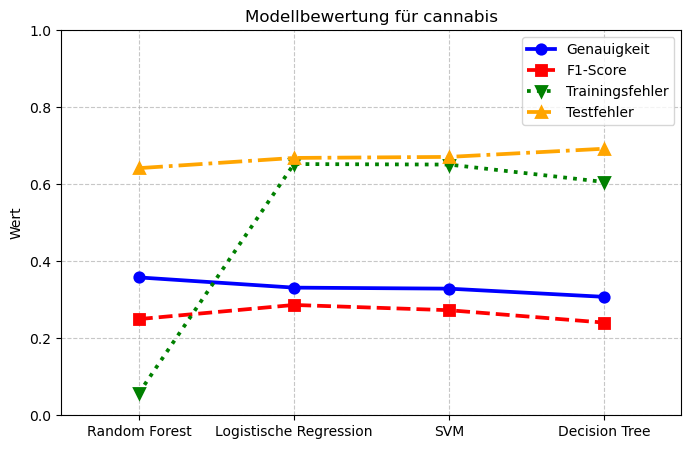

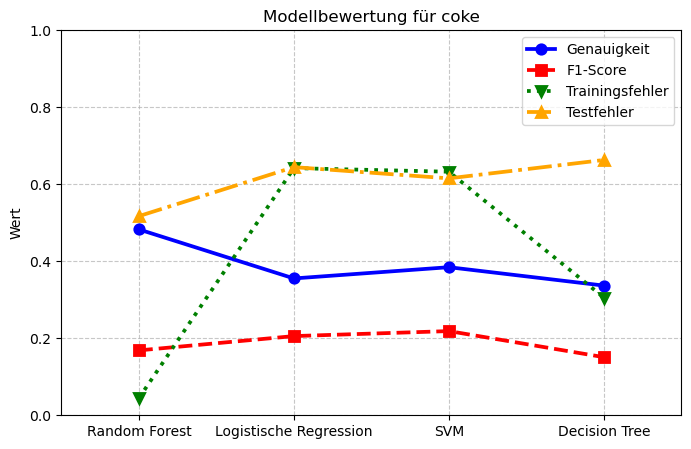

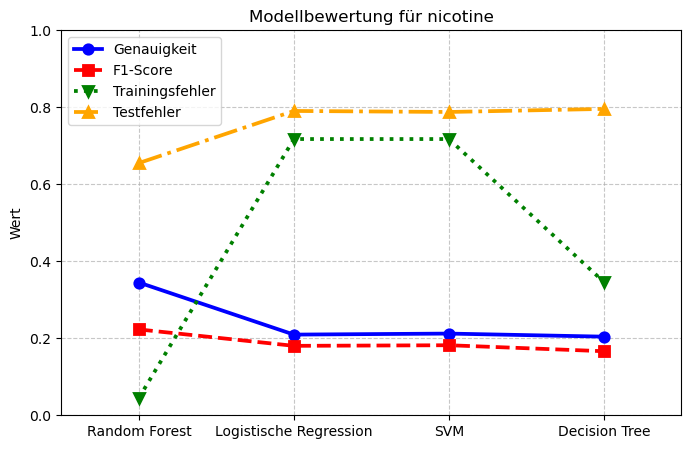

In [48]:
models = ["Random Forest", "Logistische Regression", "SVM", "Decision Tree"]

plt.figure(figsize=(8, 5))

for drug in drug_names:
    accuracies = [
        all_accuracies[drug]["Random Forest"],
        all_accuracies[drug]["Logistische Regression"],
        all_accuracies[drug]["SVM"],
        all_accuracies[drug]["Decision Tree"]
    ]
    
    f1_scores = [
        all_f1_scores[drug]["Random Forest"],
        all_f1_scores[drug]["Logistische Regression"],
        all_f1_scores[drug]["SVM"],
        all_f1_scores[drug]["Decision Tree"]
    ]

    train_errors = [
        all_train_errors[drug]["Random Forest"],
        all_train_errors[drug]["Logistische Regression"],
        all_train_errors[drug]["SVM"],
        all_train_errors[drug]["Decision Tree"]
    ]

    test_errors = [
        all_test_errors[drug]["Random Forest"],
        all_test_errors[drug]["Logistische Regression"],
        all_test_errors[drug]["SVM"],
        all_test_errors[drug]["Decision Tree"]
    ]
    
    # Plot der Genauigkeiten, F1-Scores und Fehler
    plt.figure(figsize=(8, 5))
    sns.pointplot(x=models, y=accuracies, color="blue", marker="o", linestyle="-", label="Genauigkeit")
    sns.pointplot(x=models, y=f1_scores, color="red", marker="s", linestyle="--", label="F1-Score")
    sns.pointplot(x=models, y=train_errors, color="green", marker="v", linestyle=":", label="Trainingsfehler")
    sns.pointplot(x=models, y=test_errors, color="orange", marker="^", linestyle="-.", label="Testfehler")

    plt.ylabel("Wert")
    plt.ylim(0, 1)
    plt.title(f"Modellbewertung für {drug}")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()

In [49]:
for drug in drug_names:
    print(f"\nErgebnisse für {drug}:")
    for model_name in models:  # Iteriere direkt über die Liste 'models'
        print(f"\n{model_name} - Genauigkeit: {all_accuracies[drug][model_name]:.3f}")
        print(f"\n{model_name} - F1-Score: {all_f1_scores[drug][model_name]:.3f}")
        print(f"\n{model_name} - Klassifikationsbericht:")
        print(all_classification_reports[drug][model_name])


Ergebnisse für cannabis:

Random Forest - Genauigkeit: 0.358

Random Forest - F1-Score: 0.250

Random Forest - Klassifikationsbericht:
              precision    recall  f1-score   support

         CL0       0.49      0.57      0.53        86
         CL1       0.21      0.36      0.27        28
         CL2       0.13      0.09      0.11        55
         CL3       0.22      0.11      0.14        57
         CL4       0.20      0.04      0.06        27
         CL5       0.19      0.09      0.12        32
         CL6       0.42      0.66      0.51        92

    accuracy                           0.36       377
   macro avg       0.27      0.27      0.25       377
weighted avg       0.31      0.36      0.32       377


Logistische Regression - Genauigkeit: 0.332

Logistische Regression - F1-Score: 0.287

Logistische Regression - Klassifikationsbericht:
              precision    recall  f1-score   support

         CL0       0.55      0.53      0.54        86
         CL1       0.

### Vergleich der Genauigkeiten

### Merkmalsgewichtung für trainierte Modelle

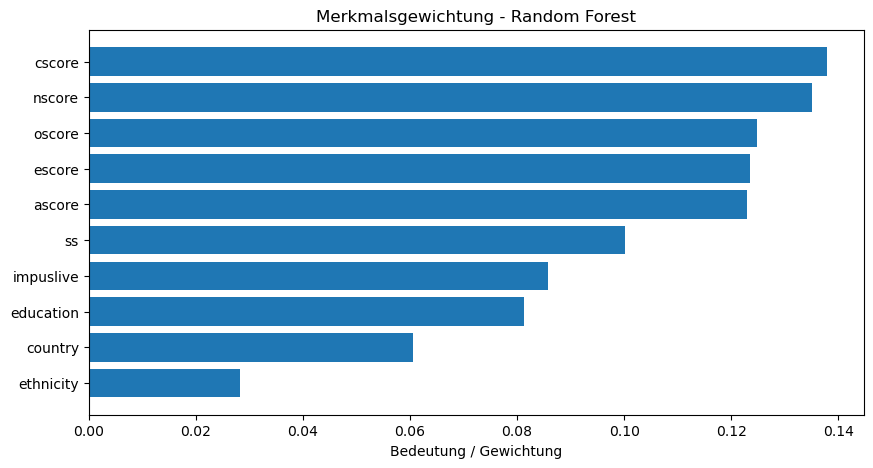

In [50]:
num_features = X_train.shape[1]
feature_names = X_train.columns.tolist() if hasattr(X_train, "columns") else [f"Merkmal {i}" for i in range(num_features)]

def zeige_feature_importance(modellname, gewichtungen):
    gewichtungen = np.array(gewichtungen)

    if len(gewichtungen) != len(feature_names):  
        return  

    sortierte_indices = np.argsort(gewichtungen)
    plt.figure(figsize=(10, 5))
    plt.title(f"Merkmalsgewichtung - {modellname}")
    plt.barh(range(len(gewichtungen)), gewichtungen[sortierte_indices], align="center")
    plt.yticks(range(len(gewichtungen)), np.array(feature_names)[sortierte_indices])
    plt.xlabel("Bedeutung / Gewichtung")
    plt.show()

if hasattr(logreg_model, "coef_") and logreg_model.coef_.size > 0:
    zeige_feature_importance("Logistische Regression", np.ravel(logreg_model.coef_))

if hasattr(svm_model, "coef_"):
    zeige_feature_importance("SVM (Linear)", np.ravel(svm_model.coef_))

if hasattr(rf_model, "feature_importances_"):
    zeige_feature_importance("Random Forest", rf_model.feature_importances_)

### Konfusionsmatrix für jedes Modell

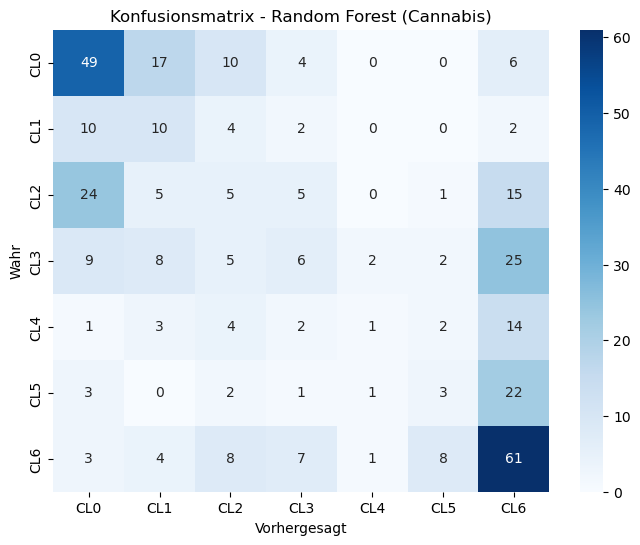

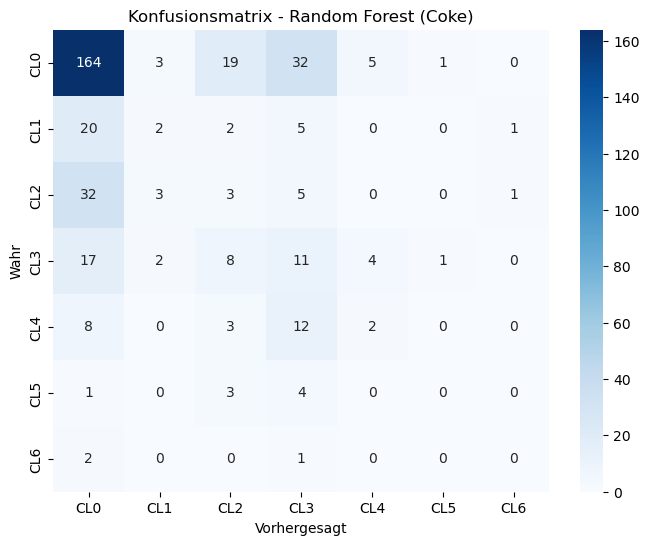

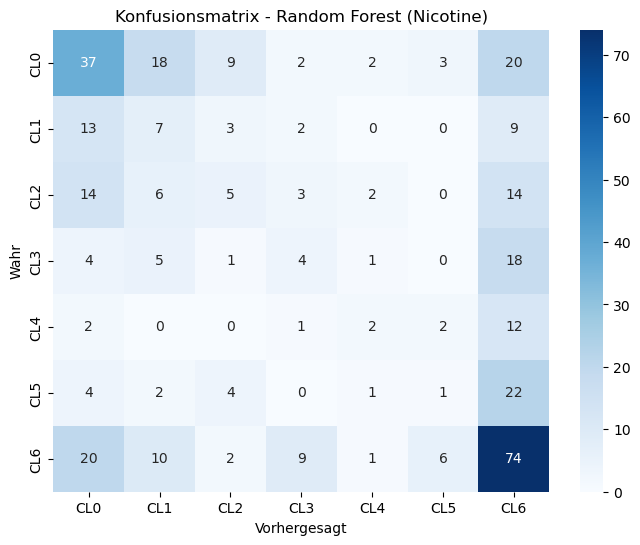

In [51]:
for drug in drug_names:
    # Berechne Konfusionsmatrix für die Droge und das Random Forest Modell
    conf_matrix = confusion_matrix(y_test[drug], y_pred_rf[drug])
    
    # Erstelle die Heatmap der Konfusionsmatrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6'], yticklabels=['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6'])
    
    plt.title(f"Konfusionsmatrix - Random Forest ({drug.capitalize()})")
    plt.xlabel("Vorhergesagt")
    plt.ylabel("Wahr")
    plt.show()

### Überprüfung der Klassen in den Vorhersagen

In [52]:
unique_classes = np.unique(y_test)
print("\nVorhergesagte Klassen:", np.unique(y_pred_rf))
print("Echte Klassen:", unique_classes)


Vorhergesagte Klassen: [{'cannabis': array(['CL0', 'CL0', 'CL1', 'CL1', 'CL6', 'CL6', 'CL2', 'CL6', 'CL6',
        'CL0', 'CL0', 'CL6', 'CL2', 'CL2', 'CL0', 'CL3', 'CL6', 'CL2',
        'CL1', 'CL0', 'CL1', 'CL0', 'CL6', 'CL1', 'CL0', 'CL1', 'CL0',
        'CL5', 'CL6', 'CL5', 'CL6', 'CL0', 'CL0', 'CL6', 'CL6', 'CL6',
        'CL6', 'CL0', 'CL2', 'CL6', 'CL6', 'CL1', 'CL6', 'CL1', 'CL6',
        'CL4', 'CL0', 'CL0', 'CL1', 'CL6', 'CL6', 'CL0', 'CL6', 'CL6',
        'CL6', 'CL0', 'CL0', 'CL2', 'CL6', 'CL3', 'CL0', 'CL6', 'CL6',
        'CL1', 'CL5', 'CL0', 'CL3', 'CL0', 'CL6', 'CL0', 'CL0', 'CL1',
        'CL0', 'CL0', 'CL6', 'CL0', 'CL0', 'CL0', 'CL6', 'CL6', 'CL1',
        'CL1', 'CL6', 'CL6', 'CL3', 'CL6', 'CL6', 'CL2', 'CL2', 'CL2',
        'CL6', 'CL0', 'CL6', 'CL1', 'CL0', 'CL4', 'CL2', 'CL6', 'CL3',
        'CL6', 'CL0', 'CL6', 'CL6', 'CL3', 'CL6', 'CL2', 'CL6', 'CL6',
        'CL6', 'CL6', 'CL6', 'CL6', 'CL2', 'CL6', 'CL6', 'CL0', 'CL6',
        'CL2', 'CL2', 'CL6', 'CL6', 'CL0

## Data Preparation

### Überprüfen auf Duplikate

In [53]:
print("Anzahl Duplikate im Datensatz: ", sum(X.duplicated()))

if sum(X.duplicated()) == 0: 
    print("Keine Duplikate im Datensatz.")

Anzahl Duplikate im Datensatz:  0
Keine Duplikate im Datensatz.


### Übersicht zu fehlenden Werten

In [54]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885 entries, 0 to 1884
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   education  1885 non-null   float64
 1   country    1885 non-null   float64
 2   ethnicity  1885 non-null   float64
 3   nscore     1885 non-null   float64
 4   escore     1885 non-null   float64
 5   oscore     1885 non-null   float64
 6   ascore     1885 non-null   float64
 7   cscore     1885 non-null   float64
 8   impuslive  1885 non-null   float64
 9   ss         1885 non-null   float64
dtypes: float64(10)
memory usage: 147.4 KB
None


Keine fehlenden oder doppelten Werte im Datensatz vorhanden. Somit müssen keine Einträge gelöscht / entfernt werden.